# RNNs on a simple example

This jupyter notebook allows you to reproduce and explore the results presented in the [dataflowr lecture on RNN](https://dataflowr.github.io/slides/module11.html)

In [1]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.special
from scipy.special import binom
import time
import torch
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def Catalan(k):
    return binom(2*k,k)/(k+1)

## 1. Generation a dataset

We have a problem, where we need to generate a dataset made of valid parenthesis strings but also invalid parenthesis string. You can skip to the end of this section to see how parenthesis strings are generated.

In [3]:
seq_max_len = 20
seq_min_len = 4

### generating positive examples

In [4]:
# convention: +1 opening parenthesis and -1 closing parenthesis

def all_parent(n, a, k=-1):
    global res
    if k==n-1 and sum(a) == 0:
        res.append(a.copy())
    elif k==n-1:
        pass
    else:
        k += 1
        if sum(a) > 0:
            a[k] = 1
            all_parent(n,a,k)

            a[k] = -1
            all_parent(n,a,k)
            a[k] = 0
        else:
            a[k] = 1
            all_parent(n,a,k)
            a[k] = 0

### generating negative examples

In [5]:
def all_parent_mistake(n, a, k=-1):
    global res
    if k==n-1 and sum(a) >= -1 and sum(a) <= 1 and min(np.cumsum(a))<0:
        res.append(a.copy())
    elif sum(a) > n-k:
        pass
    elif k==n-1:
        pass
    else:
        k += 1
        if sum(a) >= -1 and k != 0:
            a[k] = 1
            all_parent_mistake(n,a,k)

            a[k] = -1
            all_parent_mistake(n,a,k)
            a[k] = 0
        else:
            a[k] = 1
            all_parent_mistake(n,a,k)
            a[k] = 0

In [7]:
# numbering the parentheses
# example: seq of len 6
# ( ( ( ) ) )
# 0 1 2 4 5 6
# we always have ( + ) = seq_len
# 'wrong' parentheses are always closing and numbered as:
# ) )
# 7 8

def reading_par(l, n):
    res = [0]*len(l)
    s = []
    n_plus = -1
    n_moins = n+1
    c = 0
    for i in l:
        if i == 1:
            n_plus += 1
            s.append(n_plus)
            res[c] = n_plus
            c += 1
        else:
            try:
                res[c] = n-s.pop()
            except:
                res[c] = n_moins
                n_moins += 1
            c += 1
    return res

In [8]:
all_par = OrderedDict()
for n in range(seq_min_len,seq_max_len+1,2):
    a = [0]*n
    res = []
    all_parent(n=n,a=a,k=-1)
    all_par[n] = [reading_par(k,n) for k in res]

In [9]:
all_par_mist = OrderedDict()
for n in range(seq_min_len,seq_max_len+1,2):
    a = [0]*n
    res = []
    all_parent_mistake(n=n,a=a,k=-1)
    all_par_mist[n] = [reading_par(k,n) for k in res]

In [10]:
all_par[6]

[[0, 1, 2, 4, 5, 6],
 [0, 1, 5, 2, 4, 6],
 [0, 1, 5, 6, 2, 4],
 [0, 6, 1, 2, 4, 5],
 [0, 6, 1, 5, 2, 4]]

In [11]:
all_par_mist[6]

[[0, 1, 5, 6, 7, 2],
 [0, 6, 1, 5, 7, 2],
 [0, 6, 7, 1, 2, 4],
 [0, 6, 7, 1, 5, 2],
 [0, 6, 7, 8, 1, 2]]

### number of negative examples by length

In [12]:
long_mist = {i:len(l) for (i,l) in zip(all_par_mist.keys(),all_par_mist.values())}

In [13]:
long_mist

{4: 1, 6: 5, 8: 20, 10: 75, 12: 275, 14: 1001, 16: 3640, 18: 13260, 20: 48450}

### number of positive examples by length

In [14]:
Catalan_num = {i:len(l) for (i,l) in zip(all_par.keys(),all_par.values())}

In [15]:
Catalan_num

{4: 2, 6: 5, 8: 14, 10: 42, 12: 132, 14: 429, 16: 1430, 18: 4862, 20: 16796}

Sanity check, see [Catalan numbers](https://en.wikipedia.org/wiki/Catalan_number)

In [16]:
[(2*i,Catalan(i)) for i  in range(2,int(seq_max_len/2)+1)]

[(4, 2.0),
 (6, 5.0),
 (8, 14.0),
 (10, 42.0),
 (12, 132.0),
 (14, 429.0),
 (16, 1430.0),
 (18, 4862.0),
 (20, 16796.0)]

In [17]:
# nombre de suites correctes de longueur entre 4 et 10, alphabet de taille nb_symbol.
nb_symbol = 10
np.sum([Catalan(i)*int(nb_symbol/2)**i for i in range(2,int(seq_max_len/2)+1)])

174113843800.0

In [18]:
class SequenceGenerator():
    def __init__(self, nb_symbol = 10, seq_min_len = 4, seq_max_len = 10):
        self.nb_symbol = nb_symbol
        self.seq_min_len = seq_min_len
        self.seq_max_len = seq_max_len
        self.population = [i for i in range(int(nb_symbol/2))]

    def generate_pattern(self):
        len_r = random.randint(self.seq_min_len/2,self.seq_max_len/2)
        pattern = random.choices(self.population,k=len_r)
        return pattern + pattern[::-1]

    def generate_pattern_parenthesis(self, len_r = None):
        if len_r == None:
            len_r = int(2*random.randint(self.seq_min_len/2,self.seq_max_len/2))
        pattern = np.random.choice(self.population,size=int(len_r/2),replace=True)
        ind_r = random.randint(0,Catalan_num[len_r]-1)
        res = [pattern[i] if i <= len_r/2 else self.nb_symbol-1-pattern[len_r-i] for i in all_par[len_r][ind_r]]
        return res

    def generate_parenthesis_false(self):
        len_r = int(2*random.randint(self.seq_min_len/2,self.seq_max_len/2))
        pattern = np.random.choice(self.population,size=int(len_r/2),replace=True)
        ind_r = random.randint(0,long_mist[len_r]-1)
        res = [pattern[i] if i <= len_r/2
               else  self.nb_symbol-1-pattern[len_r-i] if i<= len_r
               else self.nb_symbol-1-pattern[i-len_r] for i in all_par_mist[len_r][ind_r]]
        return res

    def generate_hard_parenthesis(self, len_r = None):
        if len_r == None:
            len_r = int(2*random.randint(self.seq_min_len/2,self.seq_max_len/2))
        pattern = np.random.choice(self.population,size=int(len_r/2),replace=True)
        ind_r = random.randint(0,Catalan_num[len_r]-1)
        res = [pattern[i] if i <= len_r/2 else self.nb_symbol-1-pattern[len_r-i] for i in all_par[len_r][ind_r]]

        if len_r == None:
            len_r = int(2*random.randint(self.seq_min_len/2,self.seq_max_len/2))
        pattern = np.random.choice(self.population,size=int(len_r/2),replace=True)
        ind_r = random.randint(0,Catalan_num[len_r]-1)
        res2 = [pattern[i] if i <= len_r/2 else self.nb_symbol-1-pattern[len_r-i] for i in all_par[len_r][ind_r]]
        return res + res2

    def generate_hard_nonparenthesis(self, len_r = None):
        if len_r == None:
            len_r = int(2*random.randint(self.seq_min_len/2,self.seq_max_len/2))
        pattern = np.random.choice(self.population,size=int(len_r/2),replace=True)
        ind_r = random.randint(0,long_mist[len_r]-1)
        res = [pattern[i] if i <= len_r/2
               else  self.nb_symbol-1-pattern[len_r-i] if i<= len_r
               else self.nb_symbol-1-pattern[i-len_r] for i in all_par_mist[len_r][ind_r]]

        if len_r == None:
            len_r = int(2*random.randint(self.seq_min_len/2,self.seq_max_len/2))
        pattern = np.random.choice(self.population,size=int(len_r/2),replace=True)
        ind_r = random.randint(0,Catalan_num[len_r]-1)
        res2 = [pattern[i] if i <= len_r/2 else self.nb_symbol-1-pattern[len_r-i] for i in all_par[len_r][ind_r]]
        return  res +[self.nb_symbol-1-pattern[0]]+ res2

    def generate_false(self):
        popu = [i for i in range(nb_symbol)]
        len = random.randint(self.seq_min_len/2,self.seq_max_len/2)
        return random.choices(popu,k=len) + random.choices(popu,k=len)

    def generate_label(self, x):
        l = int(len(x)/2)
        return 1 if x[:l] == x[:l-1:-1] else 0

    def generate_label_parenthesis(self, x):
        s = []
        label = 1
        lenx = len(x)
        for i in x:
            if s == [] and i < self.nb_symbol/2:
                s.append(i)
            elif s == [] and i >= self.nb_symbol/2:
                label = 0
                break
            elif i == self.nb_symbol-1-s[-1]:
                s.pop()
            else:
                s.append(i)
        if s != []:
            label = 0
        return label

    def one_hot(self,seq):
        one_hot_seq = []
        for s in seq:
            one_hot = [0 for _ in range(self.nb_symbol)]
            one_hot[s] = 1
            one_hot_seq.append(one_hot)
        return one_hot_seq

    def generate_input(self, len_r = None, true_parent = False, hard_false = True):
        if true_parent:
            seq = self.generate_pattern_parenthesis(len_r)
        elif bool(random.getrandbits(1)):
            seq = self.generate_pattern_parenthesis(len_r)
        else:
            if hard_false:
                seq = self.generate_parenthesis_false()
            else:
                seq = self.generate_false()
        return torch.from_numpy(np.array(self.one_hot(seq))).type(torch.FloatTensor).to(device), torch.from_numpy(np.array([self.generate_label_parenthesis(seq)])).to(device)

    def generate_input_hard(self,true_parent = False):
        if true_parent:
            seq = self.generate_hard_parenthesis(self.seq_max_len)
        elif bool(random.getrandbits(1)):
            seq = self.generate_hard_parenthesis(self.seq_max_len)
        else:
            seq = self.generate_hard_nonparenthesis(self.seq_max_len)

        return torch.from_numpy(np.array(self.one_hot(seq))).type(torch.FloatTensor).to(device), torch.from_numpy(np.array([self.generate_label_parenthesis(seq)])).to(device)

In [19]:
nb_symbol = 10
generator = SequenceGenerator(nb_symbol = nb_symbol, seq_min_len = seq_min_len, seq_max_len = seq_max_len)

In [20]:
generator.generate_pattern_parenthesis()

[1, 4, 5, 1, 8, 8]

In [22]:
x = generator.generate_parenthesis_false()
print(x)

[1, 8, 0, 1, 8, 9, 9, 8, 2, 7, 3, 6, 4, 0, 9, 1]


In [23]:
generator.generate_label_parenthesis(x)

0

In [30]:
generator.generate_input()[0]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

## 2. First RNN: [Elman network](https://mlelarge.github.io/dataflowr-slides/PlutonAI/lesson7.html#16)

Initial hidden state: $h_0 =0$

Update:

$$
h_t = \mathrm{ReLU}(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
$$

Final prediction:

$$
y_T = W_{hy} h_T + b_y.
$$

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class RecNet(nn.Module):
    def __init__(self, dim_input=10, dim_recurrent=50, dim_output=2):
        super(RecNet, self).__init__()
        self.fc_x2h = nn.Linear(dim_input, dim_recurrent)
        self.fc_h2h = nn.Linear(dim_recurrent, dim_recurrent, bias = False)
        self.fc_h2y = nn.Linear(dim_recurrent, dim_output)

    def forward(self, x):
        h = x.new_zeros(1, self.fc_h2y.weight.size(1))
        for t in range(x.size(0)):
            h = torch.relu(self.fc_x2h(x[t,:]) + self.fc_h2h(h))
        return self.fc_h2y(h)

RNN = RecNet(dim_input = nb_symbol).to(device)

In [38]:
nb_train, nb_test = 40000, 1000

def train(model, data_gen):
    cross_entropy = nn.CrossEntropyLoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    loss_t = []
    corrects =[]
    labels = []
    start = time.time()
    for k in tqdm(range(nb_train)):
        input, label = data_gen()
        output = model(input)
        loss = cross_entropy(output, label)
        preds = torch.argmax(output, dim=1)
        corrects.append(preds.item() == label.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_t.append(loss.item())
        labels.append(label.item())
    print(time.time() - start)
    return loss_t, corrects, labels

def test(model, data_gen):
    corrects_test =[]
    labels_test = []
    for k in tqdm(range(nb_test)):
        input, label = data_gen()
        output = model(input)
        preds = torch.argmax(output, dim=1)
        corrects_test.append(preds.item() == label.item())
        labels_test.append(label.item())
    return corrects_test, labels_test

100%|██████████| 40000/40000 [03:18<00:00, 201.71it/s]


198.30692195892334


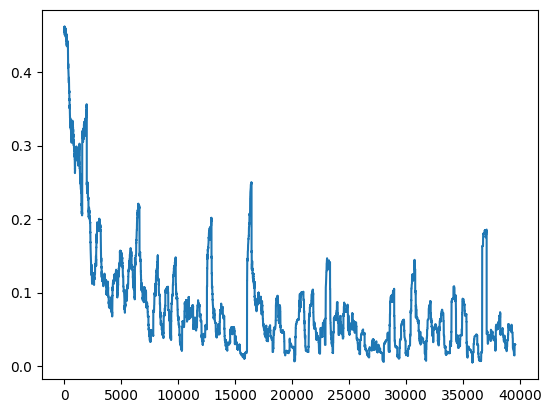

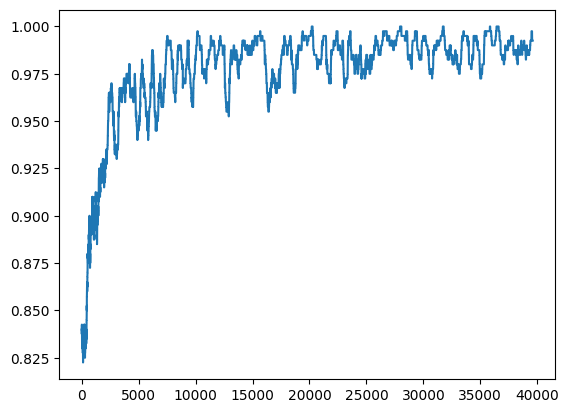

In [39]:
loss_t, corrects, _ = train(RNN, lambda: generator.generate_input(hard_false = False))

plt.plot(running_mean(loss_t, int(nb_train/100)))
plt.show()
plt.plot(running_mean(corrects, int(nb_train/100)))

Accuracy on valid parenthesis strings only:

In [40]:
corrects_test, labels_test = test(RNN, lambda: generator.generate_input(len_r=seq_max_len,true_parent=True))
np.sum(corrects_test)/nb_test

100%|██████████| 1000/1000 [00:02<00:00, 341.26it/s]


0.995

Accuracy on a test set (similar to the training set):

In [41]:
corrects_test, labels_test = test(RNN, lambda: generator.generate_input(len_r=seq_max_len, hard_false = True))
np.sum(corrects_test)/nb_test

100%|██████████| 1000/1000 [00:02<00:00, 408.35it/s]


0.851

Accuracy on a test set of hard instances, i.e. instances longer than those seen during the training :

In [45]:
generator.generate_input_hard()[0].shape

torch.Size([41, 10])

In [46]:
correctsh_test, labelsh_test = test(RNN, lambda: generator.generate_input_hard())
np.sum(correctsh_test)/nb_test

100%|██████████| 1000/1000 [00:05<00:00, 180.94it/s]


0.505

It looks like our network is always prediciting a valid label for long sequences:

In [ ]:
correctsh_test, labelsh_test = test(RNN, lambda: generator.generate_input_hard(true_parent=True))
np.sum(correctsh_test)/nb_test

100%|██████████| 1000/1000 [00:06<00:00, 160.14it/s]


0.999

## 3. [RNN with Gating](https://mlelarge.github.io/dataflowr-slides/PlutonAI/lesson7.html#20)

$$
\overline{h}_t = \mathrm{ReLU}(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
$$
Forget gate:
$$
z_t = \mathrm{sigm}(W_{xz} x_t + W_{hz}h_{t-1}+b_z)
$$
Hidden state:
$$
h_t = z_t\odot h_{t-1} +(1-z_t) \odot \overline{h}_t
$$

In [47]:
class RecNetGating(nn.Module):
    def __init__(self, dim_input=10, dim_recurrent=50, dim_output=2):
        super(RecNetGating, self).__init__()
        self.fc_x2h = nn.Linear(dim_input, dim_recurrent)
        self.fc_h2h = nn.Linear(dim_recurrent, dim_recurrent, bias = False)
        self.fc_x2z = nn.Linear(dim_input, dim_recurrent)
        self.fc_h2z = nn.Linear(dim_recurrent,dim_recurrent, bias = False)
        self.fc_h2y = nn.Linear(dim_recurrent, dim_output)

    def forward(self, x):
        h = x.new_zeros(1, self.fc_h2y.weight.size(1))
        for t in range(x.size(0)):
            z = torch.sigmoid(self.fc_x2z(x[t,:])+self.fc_h2z(h))
            hb = torch.relu(self.fc_x2h(x[t,:]) + self.fc_h2h(h))
            h = z * h + (1-z) * hb
        return self.fc_h2y(h)

RNNG = RecNetGating(dim_input = nb_symbol).to(device)

In [48]:
loss_tG, correctsG, _ = train(RNNG, lambda: generator.generate_input(hard_false = False))

plt.plot(running_mean(loss_t, int(nb_train/100)))
plt.plot(running_mean(loss_tG, int(nb_train/100)))
plt.show()
plt.plot(running_mean(corrects, int(nb_train/100)))
plt.plot(running_mean(correctsG, int(nb_train/100)))

  3%|▎         | 1205/40000 [00:13<06:59, 92.48it/s]


KeyboardInterrupt: 

Accuracy on valid parenthesis strings only:

In [ ]:
correctsG_test, labelsG_test = test(RNNG, lambda: generator.generate_input(len_r=seq_max_len,true_parent=True))
np.sum(correctsG_test)/nb_test

100%|██████████| 1000/1000 [00:06<00:00, 145.47it/s]


1.0

Accuracy on a test set (similar to the training set):

In [ ]:
correctsG_test, labelsG_test = test(RNNG, lambda: generator.generate_input(len_r=seq_max_len, hard_false = True))
np.sum(correctsG_test)/nb_test

100%|██████████| 1000/1000 [00:06<00:00, 164.87it/s]


0.481

Accuracy on a test set of hard instances, i.e. instances longer than those seen during the training :

In [ ]:
correctshG_test, labelshG_test = test(RNNG, lambda: generator.generate_input_hard())
np.sum(correctshG_test)/nb_test

100%|██████████| 1000/1000 [00:14<00:00, 69.78it/s]


0.498

## 4. [LSTM](https://mlelarge.github.io/dataflowr-slides/PlutonAI/lesson7.html#27)

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, dim_input=10, dim_recurrent=50, num_layers=4, dim_output=2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size = dim_input,
                           hidden_size = dim_recurrent,
                           num_layers = num_layers)
        self.fc_o2y = nn.Linear(dim_recurrent,dim_output)

    def forward(self, x):
        x = x.unsqueeze(1)
        output, _ = self.lstm(x)
        output = output.squeeze(1)
        output = output.narrow(0, output.size(0)-1,1)
        return self.fc_o2y(F.relu(output))

lstm = LSTMNet(dim_input = nb_symbol).to(device)

In [ ]:
input, label = generator.generate_input()
lstm(input)

tensor([[-0.0258, -0.0146]], device='cuda:0', grad_fn=<AddmmBackward0>)

100%|██████████| 40000/40000 [01:57<00:00, 341.03it/s]


117.29575181007385


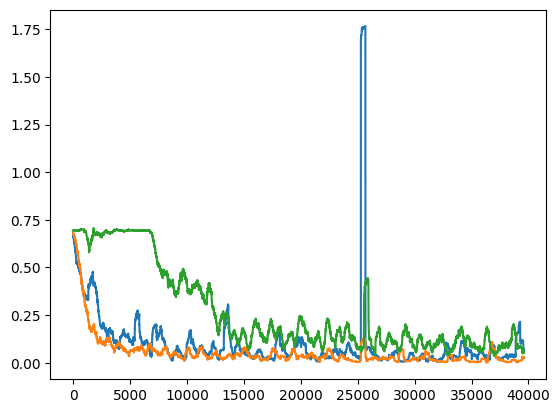

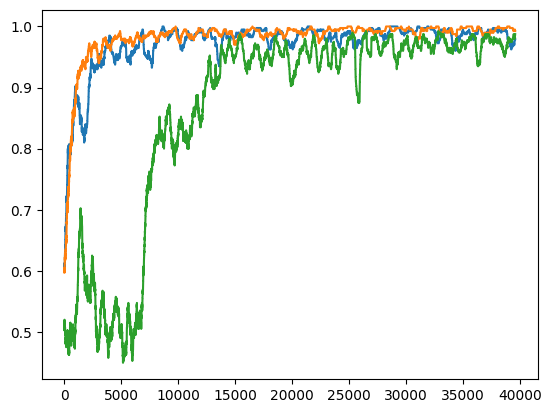

In [ ]:
loss_tL, correctsL, _ = train(lstm, lambda: generator.generate_input(hard_false = False))

plt.plot(running_mean(loss_t, int(nb_train/100)))
plt.plot(running_mean(loss_tG, int(nb_train/100)))
plt.plot(running_mean(loss_tL, int(nb_train/100)))
plt.show()
plt.plot(running_mean(corrects, int(nb_train/100)))
plt.plot(running_mean(correctsG, int(nb_train/100)))
plt.plot(running_mean(correctsL, int(nb_train/100)))

Accuracy on valid parenthesis strings only:

In [ ]:
correctsL_test, labelsL_test = test(lstm, lambda: generator.generate_input(len_r=seq_max_len,true_parent=True))
np.sum(correctsL_test)/nb_test

100%|██████████| 1000/1000 [00:00<00:00, 1206.40it/s]


1.0

Accuracy on a test set (similar to the training set):

In [ ]:
correctsL_test, labelsL_test = test(lstm, lambda: generator.generate_input(len_r=seq_max_len, hard_false = True))
np.sum(correctsL_test)/nb_test

100%|██████████| 1000/1000 [00:00<00:00, 1244.92it/s]


0.981

Accuracy on a test set of hard instances, i.e. instances longer than those seen during the training :

In [ ]:
correctshL_test, labelshL_test = test(lstm, lambda: generator.generate_input_hard())
np.sum(correctshL_test)/nb_test

100%|██████████| 1000/1000 [00:01<00:00, 954.81it/s]


0.778